### Project - All notes kept [here](<NMI - Project Progress.md>)
### Theory - All notes kept [here](<NMI - Theory.md>)

### Initial Set-up

In [5]:
#%pip install pandas
#%pip install scipy

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
%matplotlib inline

In [17]:
# Data File Import
data = pd.read_csv('/Users/amr/Documents/GitHub/NMI-Placement-2024/Data/InterpolatedL 588_2024-08-15 16-23 - BSA (37 C) 2gL 50uL (LC - A-RC 10 kDa-Water) Vcf100 Vx400g Vf400.csv')
time = data['time (min)']
signal_intensity = data['raw light scattering data: detector voltage  (V) detector 11']
absorbance_UV1 = data['UV absorbance data: absorbance  (AU) channel 1']
absorbance_UV2 = data['UV absorbance data: absorbance  (AU) channel 2']

## Raw Data

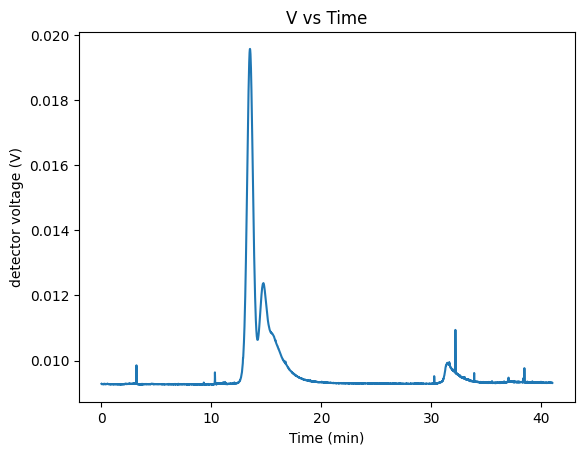

In [22]:
plt.figure()
plt.plot(time,signal_intensity)
plt.xlabel('Time (min)')
plt.ylabel('detector voltage (V)')
plt.title('V vs Time')
plt.show()

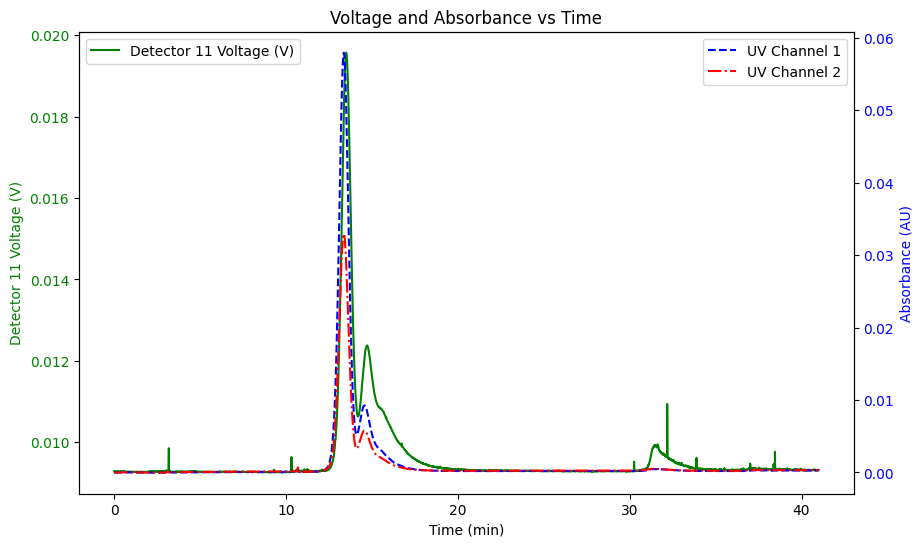

In [23]:
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first line (y1) on the first y-axis
ax1.plot(time, signal_intensity, 'g-', label='Detector 11 Voltage (V)')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Detector 11 Voltage (V)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second and third lines on the second y-axis
ax2.plot(time, absorbance_UV1, 'b--', label='UV Channel 1')
ax2.plot(time, absorbance_UV2, 'r-.', label='UV Channel 2')
ax2.set_ylabel('Absorbance (AU)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.title('Voltage and Absorbance vs Time')
plt.show()

### Rolling Mean Method

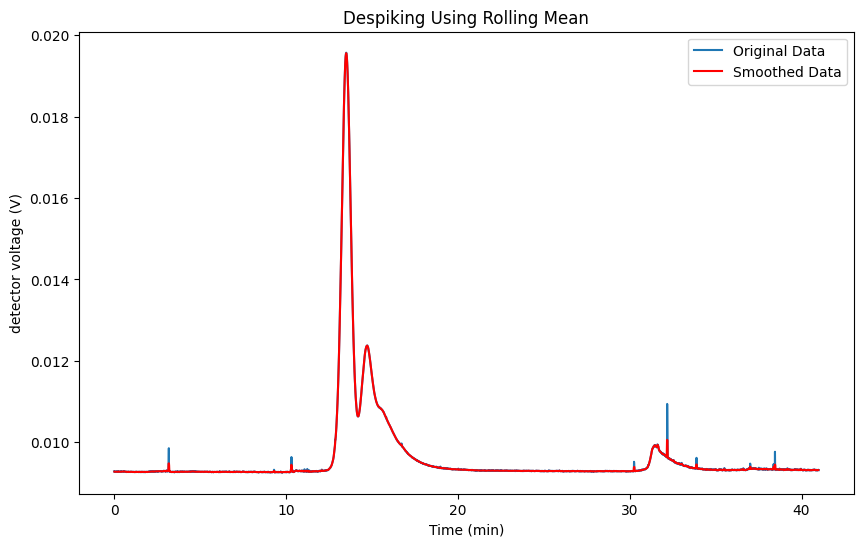

In [20]:
# Window refers to a rolling window that goes over the data and averages out the values within that window.
window_size = 5
smoothed_signalIntesity = signal_intensity.rolling(window=window_size, center=True).mean()

fig1 = plt.figure(figsize=(10, 6))
plt.plot(time, signal_intensity, label='Original Data')
plt.plot(time, smoothed_signalIntesity, label='Smoothed Data', color='red')
plt.title('Despiking Using Rolling Mean')
plt.xlabel('Time (min)')
plt.ylabel('detector voltage (V)')
plt.legend()
plt.show()

### Z-Score

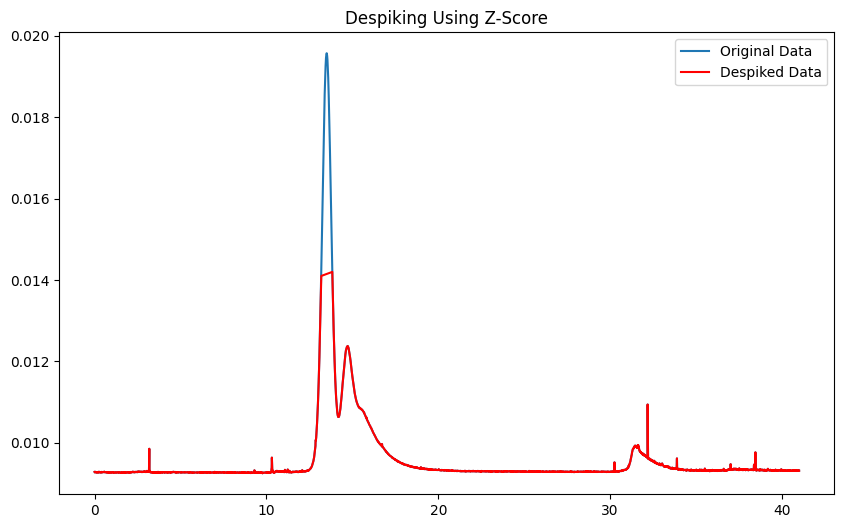

In [11]:
# Calculate the Z-score of the data
z_scores = (signal_intensity - signal_intensity.mean()) / signal_intensity.std()

# Threshold for identifying spikes
threshold = 4  # Choose an appropriate threshold

# Replace spikes with NaN or apply interpolation
signal_intensityZ = signal_intensity.copy()
signal_intensityZ[np.abs(z_scores) > threshold] = np.nan
signal_intensityZ = signal_intensityZ.interpolate()  # Interpolate to fill NaN values

# Plot the original and despiked data
fig2 = plt.figure(figsize=(10, 6))
plt.plot(time, signal_intensity, label='Original Data')
plt.plot(time, signal_intensityZ,label='Despiked Data', color='red')
plt.title('Despiking Using Z-Score')
plt.legend()
plt.show()

### Median Filter

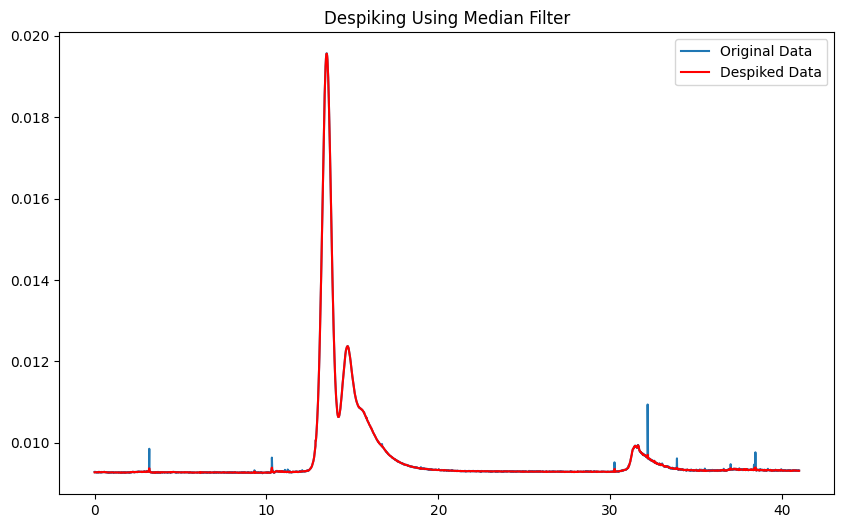

In [21]:
# Apply a median filter to smooth the data and reduce spikes - same as window just needed a new name
kernel_size = 5  # Choose an appropriate kernel size
median_signalIntensity = medfilt(signal_intensity,kernel_size)

# Plot the original and despiked data
fig3 = plt.figure(figsize=(10, 6))
plt.plot(time,signal_intensity, label='Original Data')
plt.plot(time,median_signalIntensity, label='Despiked Data', color='red')
plt.title('Despiking Using Median Filter')
plt.legend()
plt.show()

### Comparison

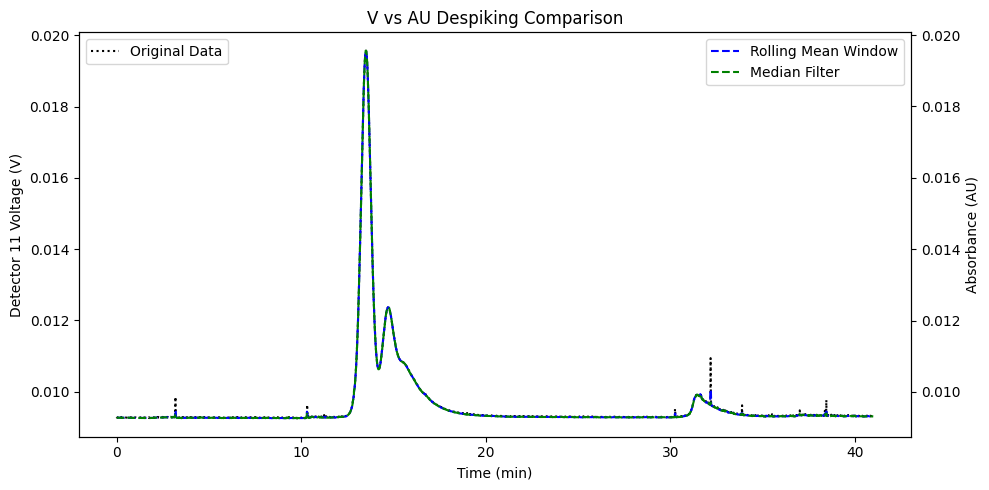

In [13]:
#Comparison
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(time,signal_intensity,'k:', label='Original Data')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Detector 11 Voltage (V)')


ax2 = ax1.twinx()
ax2.plot(time,smoothed_signalIntesity,'b--',label='Rolling Mean Window')
#ax2.plot(time,signal_intensityZ,'r--',label='Z-Score')
ax2.plot(time,median_signalIntensity,'g--', label='Median Filter')
ax2.set_ylabel('Absorbance (AU)')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('V vs AU Despiking Comparison')
plt.tight_layout()
plt.show()

# 2. Baseline Selection

### Manual Baselines

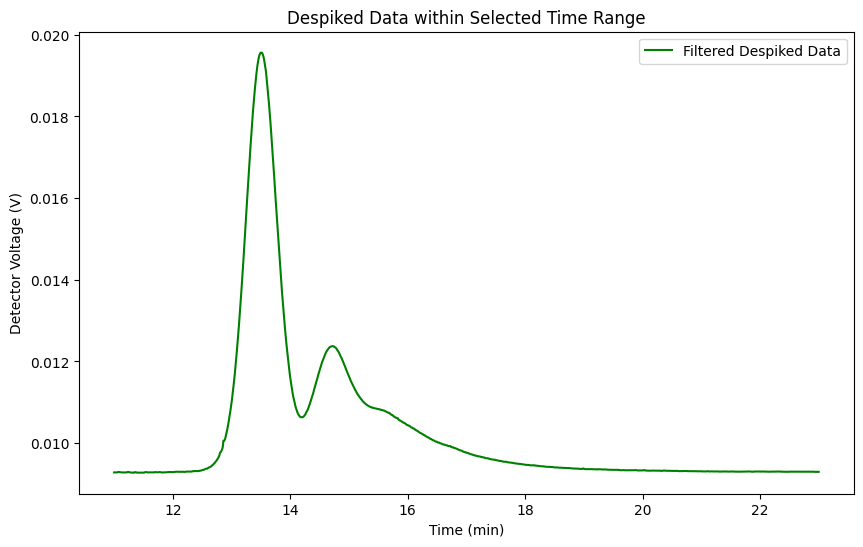

In [58]:
#Definitions
start_time = 11
end_time = 23

# Filter the data to include only defined times
filtered_indices = (time >= start_time) & (time <= end_time)
filtered_time = time[filtered_indices]
filtered_signal = median_signalIntensity[filtered_indices]

# plot
plt.figure(figsize=(10,6))
plt.plot(filtered_time,filtered_signal, label='Filtered Despiked Data',color='green')
plt.xlabel('Time (min)')
plt.ylabel('Detector Voltage (V)')
plt.title('Despiked Data within Selected Time Range')
plt.legend()
plt.show()

### Automatic Baselines
Method below is a low variance method, where the code identifies in the data where the variance (std dev) is low. This assumes that the baselines has less fluctuation compared to the rest of the data.

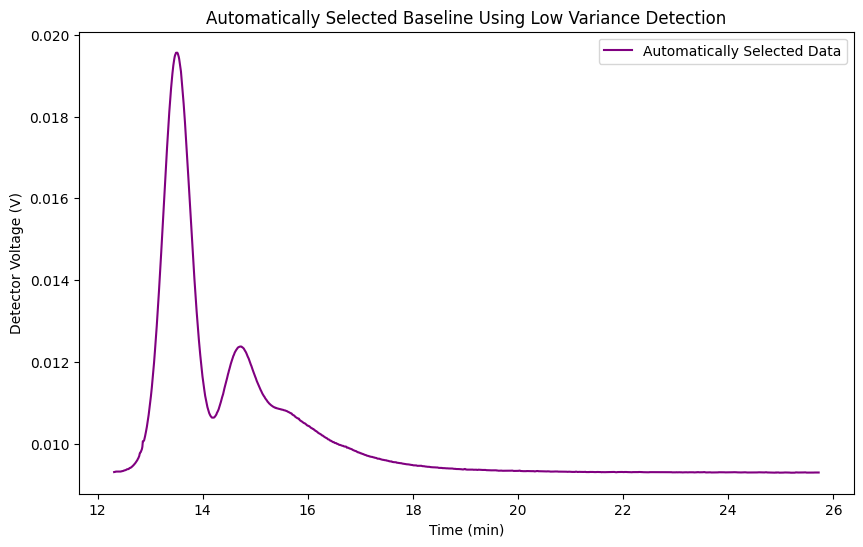

In [31]:
base_window_size = 10

# rolling std dev of the signal
rolling_std = pd.Series(median_signalIntensity).rolling(window=base_window_size).std()

# low variance threshold / baseline detection
std_threshold = np.min(rolling_std) * 2

# indices where the std dev is below the threshold
low_variance_indices = np.where(rolling_std < std_threshold)[0]

# first and last low var points as start and end times
start_index = low_variance_indices[0]
end_index = low_variance_indices[-1]

# extract time and signal for range
base_filtered_time = time[start_index:end_index+1]
base_filtered_signal = median_signalIntensity[start_index:end_index + 1]

# plot
plt.figure(figsize=(10, 6))
plt.plot(base_filtered_time, base_filtered_signal, label='Automatically Selected Data', color='purple')
plt.xlabel('Time (min)')
plt.ylabel('Detector Voltage (V)')
plt.title('Automatically Selected Baseline Using Low Variance Detection')
plt.legend()
plt.show()

# 3. Peak Selection
Note that work needs to be done to select the peaks from the automatically trimmed data. For now, I will use manual baseline plot to select the peaks.

## Retired Code

### Manual Peak Selection

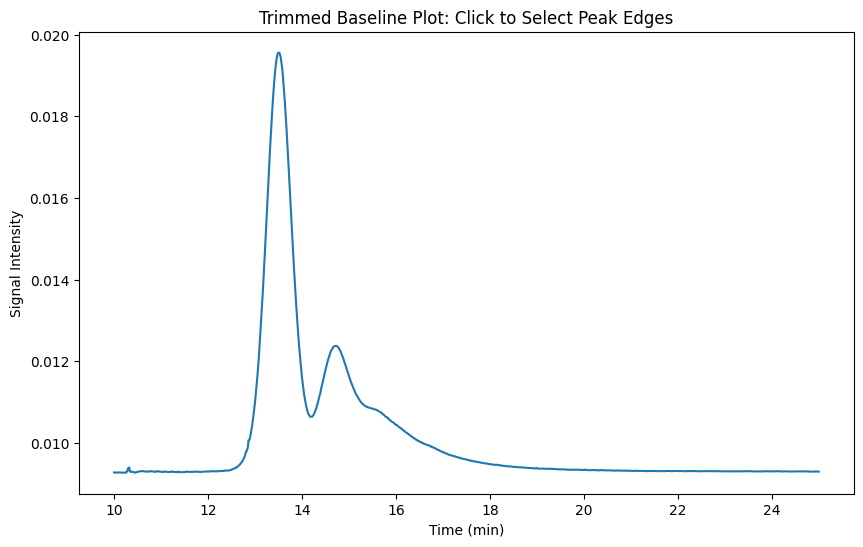

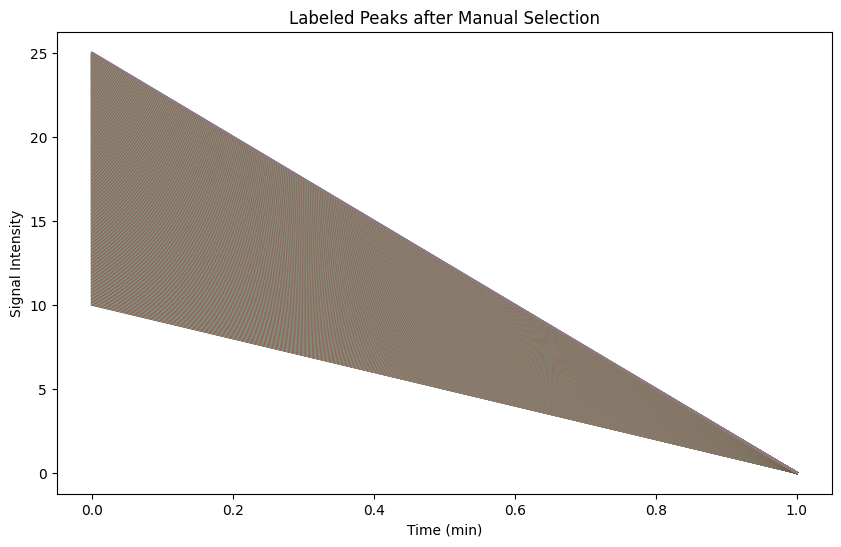

In [35]:
# baselines
baseline_start = 10
baseline_end = 25
# Function to manually select peaks
def manual_peak_selection_with_baseline(time,signal,baseline_start,baseline_end):
    selected_peaks = []
    
    def onclick(event):
        if event.inaxes:
            selected_peaks.append(event.xdata)
            plt.axvline(x=event.xdata, color = 'red', linestyle='--')
            plt.draw()
    
    #Trim the baseline
    baseline_indices = (time >= baseline_start) & (time <= baseline_end)
    trimmed_time = time[baseline_indices]
    trimmed_signal = signal[baseline_indices]
    
    #plot trimmed data
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(trimmed_time,trimmed_signal)
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Signal Intensity')
    ax.set_title('Trimmed Baseline Plot: Click to Select Peak Edges')
    
    cid = fig.canvas.mpl_connect('button_press_event',onclick)
    plt.show()
    
    plt.close(fig)
    
    #sort the peaks and lavel them
    selected_peaks.sort()
    peak_ranges = [(selected_peaks[i], selected_peaks[i+1]) for i in range(0, len(selected_peaks),2)]
    
    # plotting with labelled peaks on the trimmed baseline
    fix, ax = plt.subplots(figsize=(10,6))
    ax.plot([trimmed_time, trimmed_signal])
    
    for i, (start, end) in enumerate(peak_ranges, 1):
        ax.axvline(x=start, color='green', linestyle='--')
        ax.axvline(x=end, color='green', linestyle='--')
        ax.text((start + end) / 2, max(trimmed_signal), f'Peak {i}', color = 'blue', ha='center')
        
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Signal Intensity')
    ax.set_title('Labeled Peaks after Manual Selection')
    plt.show()
    
    return peak_ranges

peak_ranges = manual_peak_selection_with_baseline(time, median_signalIntensity, baseline_start,baseline_end)


### Automatic Peak Selection

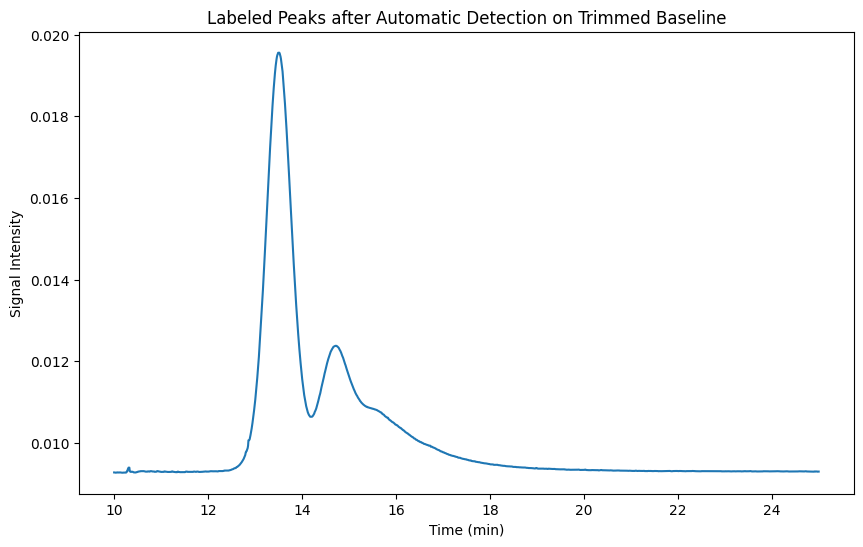

In [44]:
baseline_start = 10
baseline_end = 25

def automatic_peak_detection_with_baseline(time, signal, baseline_start, baseline_end):
    #Trim baseline
    baseline_indices = (time >= baseline_start) & (time <= baseline_end)
    trimmed_time = time[baseline_indices]
    trimmed_signal = signal[baseline_indices]
    
    #autodetect peaks
    peaks, properties = find_peaks(trimmed_signal, height=0.03, distance=5, prominence=0.03)

    # Calculate peak edges based on peak width
    left_bases = properties['left_bases']
    right_bases = properties['right_bases']
    
    #plot with labeled peaks
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(trimmed_time, trimmed_signal)
    
    for i, (start, end) in enumerate(zip(left_bases, right_bases), 1):
        ax.axvline(x=trimmed_time[start], color='green', linestyle='--')
        ax.axvline(x=trimmed_time[end], color='green', linestyle='--')
        ax.text((trimmed_time[start] + trimmed_time[end]) / 2, max(trimmed_signal), f'Peak {i}', color='blue', ha='center')

    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Signal Intensity')
    ax.set_title('Labeled Peaks after Automatic Detection on Trimmed Baseline')
    plt.show()
    
    peak_ranges = [(trimmed_time[start], trimmed_time[end]) for start, end in zip(left_bases, right_bases)]
    return peak_ranges

peak_ranges_auto = automatic_peak_detection_with_baseline(time, median_signalIntensity, baseline_start, baseline_end)

## New Code

### Normalised Signal Intensity & Baseline Selection
Signal intensity to be normalised from 0 - 1.

In [60]:
def normalise_signal(signal):
    return signal / np.max(signal)

normalised_signal = normalise_signal(median_signalIntensity)
normalised_filtered_signal = normalise_signal(filtered_signal)


### Manual Peak by Interactive Plot

In [49]:
# Function to manually select peaks by clicking on the filtered plot
def manual_peak_selection_filtered(time, signal):
    selected_peaks = []

    def onclick(event):
        if event.inaxes:
            selected_peaks.append(event.xdata)
            plt.axvline(x=event.xdata, color='red', linestyle='--')
            plt.draw()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time, signal)
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Normalised Signal Intensity')
    ax.set_title('Manual Peak Selection: Click to Select Peak Edges')
    plt.show()

    plt.close(fig)

    selected_peaks.sort()
    peak_ranges = [(selected_peaks[i], selected_peaks[i+1]) for i in range(0, len(selected_peaks), 2)]

    # Plotting with labeled peaks on the filtered data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time, signal)

    for i, (start, end) in enumerate(peak_ranges, 1):
        ax.axvline(x=start, color='green', linestyle='--')
        ax.axvline(x=end, color='green', linestyle='--')
        ax.text((start + end) / 2, 1.05, f'Peak {i}', color='blue', ha='center')

    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Normalised Signal Intensity')
    ax.set_title('Labeled Peaks after Manual Selection (Filtered Data)')
    plt.show()

    return peak_ranges

# Example usage
peak_ranges_manual_click = manual_peak_selection_filtered(filtered_time, normalised_filtered_signal)

### Manual Selection by Code Definition

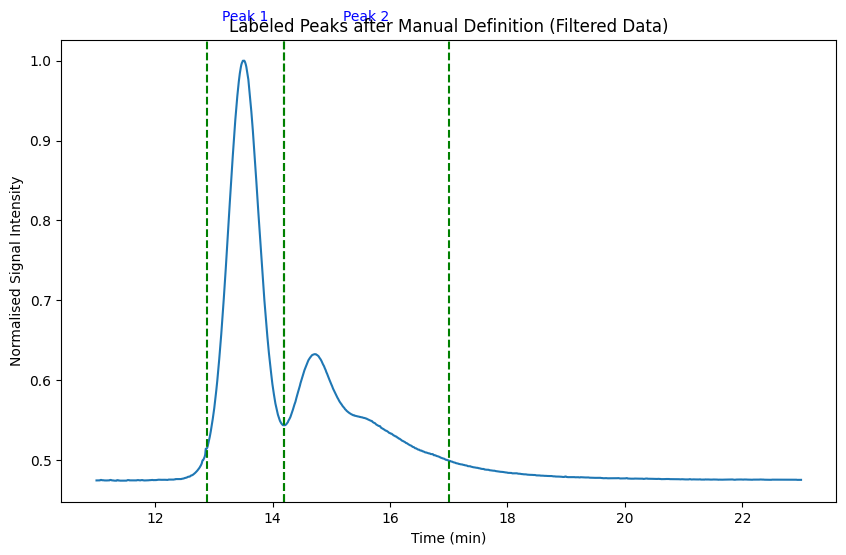

In [85]:
# Function to manually define peaks in the code (Filtered Data)
def manual_peak_definition_filtered(time, signal, peak_ranges):
    # Plotting with labeled peaks on the filtered data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time, signal)

    for i, (start, end) in enumerate(peak_ranges, 1):
        ax.axvline(x=start, color='green', linestyle='--')
        ax.axvline(x=end, color='green', linestyle='--')
        ax.text((start + end) / 2, 1.05, f'Peak {i}', color='blue', ha='center')

    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Normalised Signal Intensity')
    ax.set_title('Labeled Peaks after Manual Definition (Filtered Data)')
    plt.show()

    return peak_ranges

# Example usage
peak_ranges_manual_code = manual_peak_definition_filtered(filtered_time, normalised_filtered_signal, peak_ranges=[(12.8866, 14.1943), (14.1943, 17.0012)])

#### Saving Datasets for this method

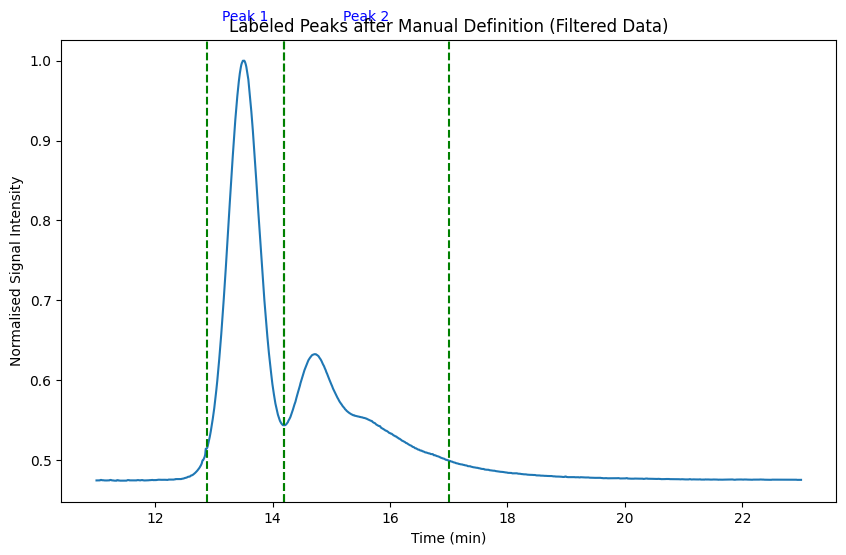

In [86]:
# Function to manually define peaks in the code (Filtered Data)
def manual_peak_definition_filtered(time, signal, peak_ranges):
    # Plotting with labeled peaks on the filtered data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time, signal)

    for i, (start, end) in enumerate(peak_ranges, 1):
        ax.axvline(x=start, color='green', linestyle='--')
        ax.axvline(x=end, color='green', linestyle='--')
        ax.text((start + end) / 2, 1.05, f'Peak {i}', color='blue', ha='center')

    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Normalised Signal Intensity')
    ax.set_title('Labeled Peaks after Manual Definition (Filtered Data)')
    plt.show()

    # Extract the data corresponding to each peak range
    peak_data = []
    for start, end in peak_ranges:
        peak_indices = (time >= start) & (time <= end)
        peak_time = time[peak_indices]
        peak_signal = signal[peak_indices]
        peak_data.append((peak_time, peak_signal))
    
    return peak_data

# Example usage
peak_ranges_manual_code = [(12.8866, 14.1943), (14.1943, 17.0012)]
peak_data = manual_peak_definition_filtered(filtered_time, normalised_filtered_signal, peak_ranges_manual_code)

# Storing the datasets for future use
peak1_time, peak1_signal = peak_data[0]
peak2_time, peak2_signal = peak_data[1]

### Autoamtic Peak Detection

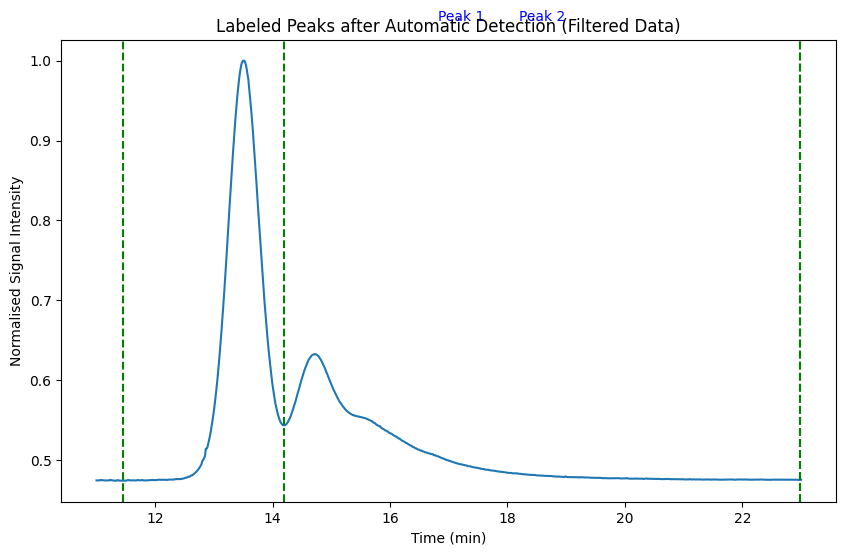

In [83]:
def automatic_peak_detection_filtered(time, signal):
    # Detect peaks
    peaks, properties = find_peaks(signal, height=0.05, distance=1, prominence=0.05)
    
    # Extract left and right bases of peaks
    left_bases = properties['left_bases']
    right_bases = properties['right_bases']

    # Plotting with labeled peaks on the filtered data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time, signal)
    
    for i in range(len(peaks)):
        start = left_bases[i]
        end = right_bases[i]

        # Plot vertical lines at the edges of each peak
        ax.axvline(x=time.iloc[start], color='green', linestyle='--')
        ax.axvline(x=time.iloc[end], color='green', linestyle='--')
        ax.text((time.iloc[start] + time.iloc[end]) / 2, 1.05, f'Peak {i + 1}', color='blue', ha='center')

    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Normalised Signal Intensity')
    ax.set_title('Labeled Peaks after Automatic Detection (Filtered Data)')
    plt.show()

    # Return the peak ranges
    peak_ranges = [(time.iloc[start], time.iloc[end]) for start, end in zip(left_bases, right_bases)]
    return peak_ranges

# Example usage
peak_ranges_auto = automatic_peak_detection_filtered(filtered_time, normalised_filtered_signal)

# 4. Molar Mass Calculations

## Rayleigh Ration ($R_{\theta}$) - Using reference data

In [103]:
# Constants
R_theta_toluene = 1.406e-5  # Rayleigh ratio of toluene in cm^-1
V_theta_toluene = 1.0  # Example value for toluene detector voltage
V_theta_baseline = 0.1  # Example baseline voltage
distance_r = 1.0  # Distance from the scattering volume to the detector (in cm)
incident_intensity = 5.0  # Example value for incident intensity

# Example values for your sample
V_theta_sample = 0.5  # Detector voltage for your sample

# Calculate Rayleigh ratio for the sample
R_theta_sample = ((V_theta_sample - V_theta_baseline) / (V_theta_toluene - V_theta_baseline)) * R_theta_toluene

print(f"Rayleigh Ratio (R_theta) for the sample: {R_theta_sample:.6e} cm^-1")

Rayleigh Ratio (R_theta) for the sample: 6.248889e-06 cm^-1


## Rayleigh Ration ($R_{\theta}$) - Using experimental data

In [104]:
import numpy as np

# Constants
n = 1.335  # Refractive index of solvent (PBS)
dn_dc = 0.185  # Refractive index increment (dn/dc), example value
lambda_laser = 660e-9  # Wavelength of the laser in meters
NA = 6.02214076e23  # Avogadro's number

# Optical constant K
K = (4 * np.pi**2 * n**2 * (dn_dc)**2) / (lambda_laser**4 * NA)

# Example values from your experiment
concentration = 1e-3  # Concentration in g/mL (from UV data)
molar_mass = 1e5  # Example molar mass in g/mol, replace with actual value if known
scattered_intensity = 2e-6  # Scattered intensity, relative to incident intensity
P_theta = 1.0  # Assuming small particle approximation, P(theta) ≈ 1

# Calculate the Rayleigh ratio
R_theta = (scattered_intensity * molar_mass * concentration * P_theta) / K

print(f"Calculated Rayleigh Ratio (R_theta): {R_theta:.6e} cm^-1")

Calculated Rayleigh Ratio (R_theta): 9.490540e-06 cm^-1


## MM

In [102]:
uv_absorbance_1 = data['UV absorbance data: absorbance  (AU) channel 1']
uv_absorbance_2 = data['UV absorbance data: absorbance  (AU) channel 2']
flow_rate = 1.0  # Example flow rate in mL/min; replace with your actual flow rate

# Constants for UV detector calibration
epsilon = 1.0  # Extinction coefficient in (L/mol*cm); replace with your actual value
path_length = 1.0  # Path length in cm; replace with your actual value
alpha = epsilon * path_length  # Calibration constant

# Define the start and end times for the peak
start_time = 12.8866
end_time = 14.1943

# Filter the data for the peak
filtered_indices = (time >= start_time) & (time <= end_time)
filtered_time = time[filtered_indices].reset_index(drop=True)
filtered_uv_1 = uv_absorbance_1[filtered_indices].reset_index(drop=True)
filtered_uv_2 = uv_absorbance_2[filtered_indices].reset_index(drop=True)

# Calculate concentration for each slice using UV absorbance
concentration_1 = filtered_uv_1 / alpha  # Concentration from UV channel 1
concentration_2 = filtered_uv_2 / alpha  # Concentration from UV channel 2

# Calculate volume for each slice (assuming uniform flow rate)
delta_t = (filtered_time.iloc[1] - filtered_time.iloc[0]) * 60  # Convert minutes to seconds
delta_v = flow_rate * delta_t / 60  # Volume in mL for each slice

# Calculate the mass for each slice
mass_1 = concentration_1 * delta_v  # Mass from UV channel 1
mass_2 = concentration_2 * delta_v  # Mass from UV channel 2

# Sum the masses to get the total mass of the solute in the peak
total_mass_1 = np.sum(mass_1)
total_mass_2 = np.sum(mass_2)

print(f"Total Mass from UV Channel 1: {total_mass_1:.6f} g")
print(f"Total Mass from UV Channel 2: {total_mass_2:.6f} g")

# Molar Mass Calculation using light scattering data
# Assuming you have the scattering data R_theta, and optical constant K

R_theta = 1e-6  # Example Rayleigh ratio; replace with your actual value
P_theta = 1.0  # Example form factor; typically 1 for small particles or isotropic scattering
K = 1.0  # Optical constant; replace with your actual value

# Molar Mass calculation (Example using Channel 1)
molar_mass_1 = R_theta / (K * concentration_1.mean() * P_theta)

print(f"Molar Mass (Channel 1): {molar_mass_1:.2f} g/mol")

# Repeat for Channel 2 if needed
molar_mass_2 = R_theta / (K * concentration_2.mean() * P_theta)
print(f"Molar Mass (Channel 2): {molar_mass_2:.2f} g/mol")

Total Mass from UV Channel 1: 0.038720 g
Total Mass from UV Channel 2: 0.022454 g
Molar Mass (Channel 1): 0.00 g/mol
Molar Mass (Channel 2): 0.00 g/mol


# 5. Hydrodynamic Radius from LS

## Constant Definitions

In [91]:
# constants
k_B = 1.380649e-23  # Boltzmann constant, J/K
T = 296.15  # Temperature in Kelvin (23 °C)
eta = 0.9324e-3  # Viscosity in Pa·s (0.9324 cP)
lambda_laser = 660e-9  # Wavelength of the laser in meters (660 nm)
n = 1.335  # Approximate refractive index for PBS at 23°C
theta = 135 * np.pi / 180  # Scattering angle in radians (135 degrees)
calibration_constant = 5.5068e-5  # Calibration constant

## Correlation Function

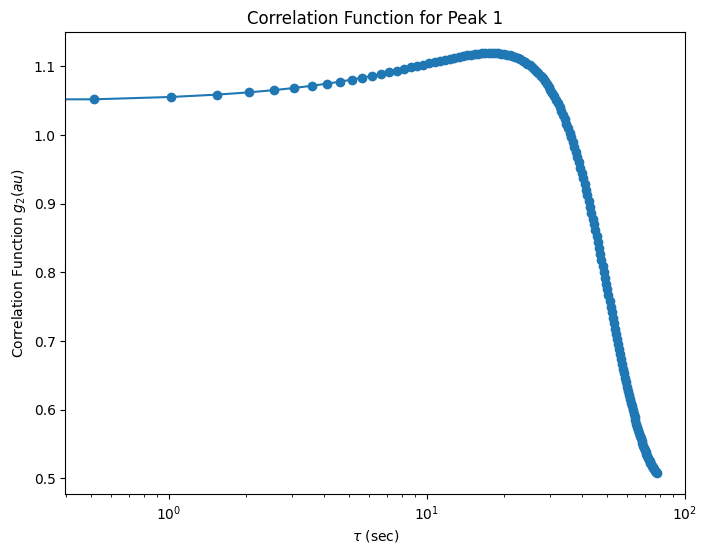

In [92]:
# Define the start and end times for peak 1 (replace with actual values)
start_time = 12.8866
end_time = 14.1943

# Filter the data for peak 1
filtered_indices = (time >= start_time) & (time <= end_time)
filtered_time = time[filtered_indices]
filtered_signal = median_signalIntensity[filtered_indices]

# Calculate the mean intensity
mean_intensity = np.mean(filtered_signal)

# Calculate the correlation function
def calculate_correlation_function(signal):
    N = len(signal)
    g2 = np.zeros(N)
    for tau in range(N):
        if tau == 0:
            g2[tau] = 1
        else:
            sum_products = 0
            for t in range(N - tau):
                sum_products += signal[t] * signal[t + tau]
            g2[tau] = sum_products / (N - tau) / (mean_intensity**2)
    return g2

# Calculate g2(tau)
g2_tau = calculate_correlation_function(filtered_signal)

# Plot the correlation function
tau_values = np.arange(len(g2_tau)) * (filtered_time.iloc[1] - filtered_time.iloc[0]) * 60  # Convert to seconds
plt.figure(figsize=(8, 6))
plt.plot(tau_values, g2_tau, 'o-')
plt.xscale('log')
plt.xlabel(r'$\tau$ (sec)')
plt.ylabel('Correlation Function $g_2(\tau)$')
plt.title('Correlation Function for Peak 1')
plt.show()

### Fit Correlation Function to Extract Decay Rate ($\Gamma$)

In [93]:
# Define the model function for fitting
def correlation_function_model(tau, Gamma):
    return 1 + np.exp(-2 * Gamma * tau)

# Fit the correlation function to determine Gamma
popt, _ = curve_fit(correlation_function_model, tau_values, g2_tau, bounds=(0, [np.inf]))
Gamma = popt[0]

print(f"Fitted decay rate (Gamma): {Gamma:.2e} s^(-1)")

Fitted decay rate (Gamma): 2.77e+00 s^(-1)


### Hydrodynamic Radius ($R_h$)

Hydrodynamic Radius (R_h): 46394.90 nm
Fitted decay rate (Gamma): 2.77e+00 s^(-1)


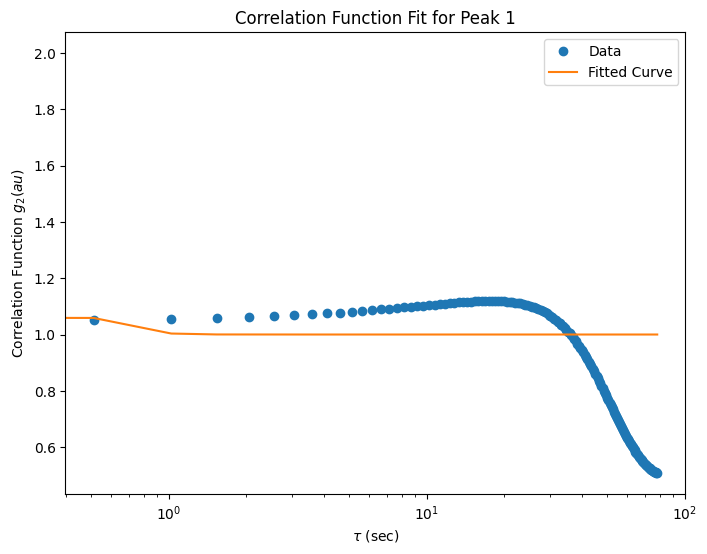

In [98]:
# Scattering vector
q = (4 * np.pi * n / lambda_laser) * np.sin(theta / 2)

# Calculate the diffusion coefficient
D = Gamma / (q**2)

# Calculate the hydrodynamic radius
R_h = k_B * T / (6 * np.pi * eta * D)

print(f"Hydrodynamic Radius (R_h): {R_h * 1e9:.2f} nm")
print(f"Fitted decay rate (Gamma): {Gamma:.2e} s^(-1)")
# Plot the correlation function with the fit
plt.figure(figsize=(8, 6))
plt.plot(tau_values, g2_tau, 'o', label='Data')
plt.plot(tau_values, correlation_function_model(tau_values, *popt), '-', label='Fitted Curve')
plt.xscale('log')
plt.xlabel(r'$\tau$ (sec)')
plt.ylabel('Correlation Function $g_2(\tau)$')
plt.title('Correlation Function Fit for Peak 1')
plt.legend()
plt.show()

diff

Fitted decay rate (Gamma): 3.22e-02 s^(-1)
Hydrodynamic Radius (R_h): 3984622.71 nm


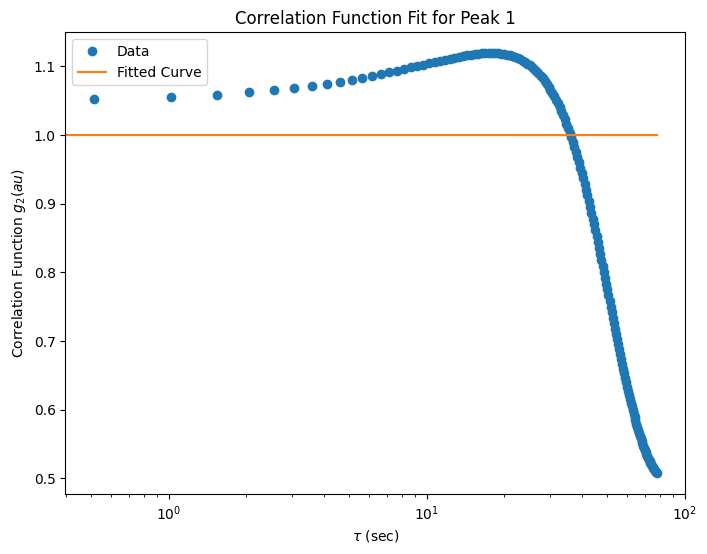

In [101]:

# Constants
k_B = 1.380649e-23  # Boltzmann constant, J/K
T = 296.15  # Temperature in Kelvin (23 °C)
eta = 0.9324e-3  # Viscosity in Pa·s (0.9324 cP)
lambda_laser = 660e-9  # Wavelength of the laser in meters (660 nm)
n = 1.335  # Refractive index for PBS at 23°C
theta = 135 * np.pi / 180  # Scattering angle in radians (135 degrees)
calibration_constant = 5.5068e-5  # Calibration constant

# Scattering vector
q = (4 * np.pi * n / lambda_laser) * np.sin(theta / 2)

# Load the data
file_path ='/Users/amr/Documents/GitHub/NMI-Placement-2024/Data/InterpolatedL 588_2024-08-15 16-23 - BSA (37 C) 2gL 50uL (LC - A-RC 10 kDa-Water) Vcf100 Vx400g Vf400.csv'
data = pd.read_csv(file_path)

# Extract relevant columns
time = data['time (min)']
detector_signal = data['raw light scattering data: detector voltage  (V) detector 11']

# Define the start and end times for peak 1
start_time = 12.8866
end_time = 14.1943

# Filter the data for peak 1
filtered_indices = (time >= start_time) & (time <= end_time)
filtered_time = time[filtered_indices].reset_index(drop=True)
filtered_signal = detector_signal[filtered_indices].reset_index(drop=True)


# Calculate the mean intensity
mean_intensity = np.mean(filtered_signal)

# Calculate the correlation function
def calculate_correlation_function(signal):
    N = len(signal)
    g2 = np.zeros(N)
    for tau in range(N):
        if tau == 0:
            g2[tau] = 1
        else:
            sum_products = 0
            for t in range(N - tau):
                sum_products += signal[t] * signal[t + tau]
            g2[tau] = sum_products / (N - tau) / (mean_intensity**2)
    return g2

# Calculate g2(tau)
g2_tau = calculate_correlation_function(filtered_signal)

# Fit the correlation function to determine Gamma
tau_values = np.arange(len(g2_tau)) * (filtered_time.iloc[1] - filtered_time.iloc[0]) * 60  # Convert to seconds
def correlation_function_model(tau, Gamma):
    return 1 + calibration_constant * np.exp(-2 * Gamma * tau)

popt, _ = curve_fit(correlation_function_model, tau_values, g2_tau, bounds=(0, [np.inf]))
Gamma = popt[0]

# Calculate the diffusion coefficient
D = Gamma / (q**2)

# Calculate the hydrodynamic radius
R_h = k_B * T / (6 * np.pi * eta * D)

# Output results
print(f"Fitted decay rate (Gamma): {Gamma:.2e} s^(-1)")
print(f"Hydrodynamic Radius (R_h): {R_h * 1e9:.2f} nm")

# Plot the correlation function with the fit
plt.figure(figsize=(8, 6))
plt.plot(tau_values, g2_tau, 'o', label='Data')
plt.plot(tau_values, correlation_function_model(tau_values, *popt), '-', label='Fitted Curve')
plt.xscale('log')
plt.xlabel(r'$\tau$ (sec)')
plt.ylabel('Correlation Function $g_2(\tau)$')
plt.title('Correlation Function Fit for Peak 1')
plt.legend()
plt.show()